## CPU vs GPU Cross Correlation Benchmark

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as pn
import tqdm
from flowdec import data as fd_data
from cytokit.ops import drift_compensation
from skimage.feature import register_translation
from skimage.transform import rescale
from skimage.exposure import rescale_intensity

In [2]:
acq = fd_data.bead_25pct()

In [3]:
img = acq.data
img = rescale_intensity(img, out_range='uint8').astype(np.uint8)
img.shape

(64, 64, 64)

In [4]:
from timeit import default_timer as timer

def run(op):
    start = timer()
    op()
    end = timer()
    return end - start

def benchmark(img):
    op = drift_compensation.TranslationCalculator(3)
    op.initialize()
    
    df = []
    for scale_factor in tqdm.tqdm(np.arange(1., 5., .2)):
        imgs = rescale(img, scale_factor, anti_aliasing=False, mode='constant', 
                       multichannel=False, preserve_range=True).astype(np.uint8)
        
        df.append({
            'scale_factor': scale_factor,
            'size': imgs.size,
            'shape': imgs.shape,
            'cpu': run(lambda: register_translation(imgs, imgs)),
            'gpu': run(lambda: op.run(imgs, imgs))
        })
    return pd.DataFrame(df)


In [5]:
df = benchmark(img)

100%|██████████| 20/20 [05:49<00:00, 58.68s/it]


In [7]:
df

,cpu,gpu,scale_factor,shape,size
0,0.081813,1.721321,1.0,"(64, 64, 64)",262144
1,0.189963,0.033839,1.2,"(77, 77, 77)",456533
2,0.185364,0.051471,1.4,"(90, 90, 90)",729000
3,0.429476,0.069251,1.6,"(102, 102, 102)",1061208
4,0.669888,0.097829,1.8,"(115, 115, 115)",1520875
5,0.721086,0.117296,2.0,"(128, 128, 128)",2097152
6,2.158388,0.130621,2.2,"(141, 141, 141)",2803221
7,1.782249,0.189182,2.4,"(154, 154, 154)",3652264
8,5.586183,0.268170,2.6,"(166, 166, 166)",4574296
9,15.786713,0.322744,2.8,"(179, 179, 179)",5735339


In [13]:
df[['size', 'cpu', 'gpu']].melt(id_vars='size').head()

,size,variable,value
0,262144,cpu,0.081813
1,456533,cpu,0.189963
2,729000,cpu,0.185364
3,1061208,cpu,0.429476
4,1520875,cpu,0.669888


/usr/local/lib/python3.5/dist-packages/plotnine/stats/smoothers.py:146: UserWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  warnings.warn("Confidence intervals are not yet implemented"
/usr/local/lib/python3.5/dist-packages/plotnine/stats/smoothers.py:146: UserWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  warnings.warn("Confidence intervals are not yet implemented"


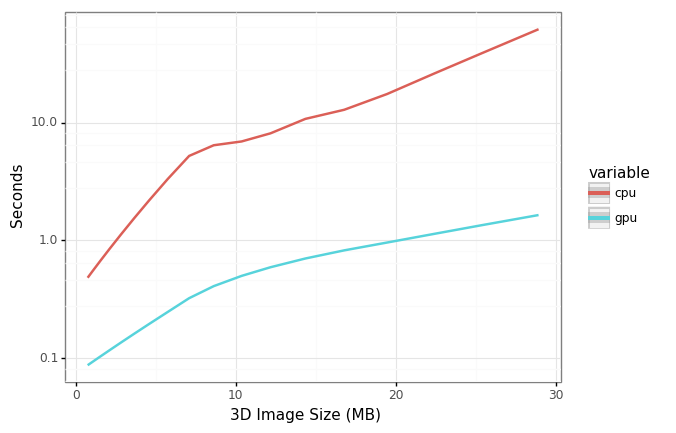

<ggplot: (8749534668001)>

In [26]:
(
    pn.ggplot(
        df.query('scale_factor > 1.2').assign(mb=lambda df: df['size']/1000000)[['mb', 'cpu', 'gpu']].melt(id_vars='mb'), 
        pn.aes(x='mb', y='value', color='variable')
    ) +
    pn.geom_smooth() +
    pn.scale_y_log10() + 
    pn.theme_bw() +
    pn.xlab('3D Image Size (MB)') +
    pn.ylab('Seconds')
)

In [30]:
(1*1008*1344)/1000000, (11*1008*1344)/1000000

(1.354752, 14.902272)